In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis,integral,integral_Lmin_Lmax
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq
import fitting
from scipy.optimize import minimize

2024-10-21 16:59:18.414627: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [4]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [5]:
d_desi = Planck18.distmod(z_desi).value

In [6]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [7]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.4)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

42124


In [8]:
apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [9]:
gamma1, gamma2, L_star, phi_star = get_lfpars("shen20",2.3005)
alpha = -(gamma1+1)
beta = -(gamma2+1)
_, _, L_star, phi_star = get_lfpars_shen20((2.3+2.301)/2)
L_min = abs_mag_to_L(apr_mag_r.max()-k_rr.mean()-d_desi.mean()-1.7)/L_star
#L_min = 0.01
#print(integral(0.1,alpha,beta))
N_obs = fitting.N_obs(2.3,2.301)
#print(integral(0.1,alpha,beta).dtype)
N = N_obs(18.326392827473228,0.6586,1.7,alpha,beta,L_min,k_rr)
def eff(m):
    eff = jnp.where(m < 18.326392827473228, 1, 10**(-0.6586*(m-18.326392827473228)/2.5))
    return eff
lg_lkh = fitting.ln_posterior(eff)

In [10]:
def eff(m,b,m0):
    eff = jnp.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
    return eff

ln_posterior = fitting.ln_posterior(eff)

def neg_likelihood(params,apr_mag,k,mu,apr_mag_err):
    m0,b,x = params
    #Lmin = abs_mag_to_L(apr_mag_r.max()-k_rr.mean()-d_desi.mean()-x)/L_star
    
    log_likelihood = ln_posterior(m0, b, x, apr_mag, k, mu, apr_mag_err,0.0001)
    return -log_likelihood

In [11]:
initial_guess = [18,0.5,1.85]
bounds = [(0,20),(10,20),(-10,-2)]

result = minimize(
    neg_likelihood, 
    initial_guess, 
    args=(apr_mag_r, k_rr, d_desi, apr_mag_r_err), 
    method='L-BFGS-B',
    bounds=bounds
)

optimal_params = result.x
optimal_likelihood = -result.fun  

print(f"Optimal parameters: m0 = {optimal_params[0]}, b = {optimal_params[1]}, x = {optimal_params[2]}")
print(f"Maximum likelihood value: {optimal_likelihood}")

first term 78216.02900011317
Poisson term 383058.8336491201
N_obs 103265.01980438654
first term 78216.02900006087
Poisson term 383058.83314879215
N_obs 103265.02064942272
first term 78216.02900051053
Poisson term 383058.83365482406
N_obs 103265.01979475282
first term 78216.02954790753
Poisson term 383058.83314879215
N_obs 103265.02064942272
first term 516229.9647726733
Poisson term -397655.99442712514
N_obs 7.947015557571795e-05
first term 516229.9647726733
Poisson term -397655.9934537782
N_obs 7.947015741201163e-05
first term 516229.964772525
Poisson term -397655.9944241038
N_obs 7.947015558141781e-05
first term 516229.9642255839
Poisson term -397655.9954004721
N_obs 7.947015373942429e-05
first term 182211.78276873165
Poisson term 339657.3141792241
N_obs 3446.411862364822
first term 182211.78276873165
Poisson term 339657.3149849789
N_obs 3446.4119341625506
first term 182211.7827691011
Poisson term 339657.3141724084
N_obs 3446.4118617575045
first term 182211.78222162294
Poisson term 33

In [12]:
'''
params = [16.0259,0.45,1.85]
neg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)
'''

'\nparams = [16.0259,0.45,1.85]\nneg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)\n'

  0%|          | 0/20 [00:00<?, ?it/s]

first term 77776.39317249741
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term 77784.23162936061
Poisson term -1684286.6569695272
N_obs 2301361.617966021
first term 77792.02396833598
Poisson term -552359.9835862755
N_obs 1139837.9983262448
first term 77799.77150014348
Poisson term -88809.92951646633
N_obs 652809.9032555284
first term 77807.47550583465
Poisson term 115223.02520651463
N_obs 431319.17891854455
first term 77815.13723666487
Poisson term 213261.79104077735
N_obs 320812.0002539685
first term 77822.75791396957
Poisson term 265142.27827510965
N_obs 260093.2659271544
first term 77830.33872904361
Poisson term 295313.90118600556
N_obs 223542.42358747788
first term 77837.88084302472
Poisson term 314388.06576505204
N_obs 199721.93063326034
first term 77845.38538678111
Poisson term 327306.8697744451
N_obs 183155.61297454513
first term 77852.8534608035
Poisson term 336549.9543736675
N_obs 171026.22420657158
first term 77860.28613510163
Poisson term 343454.71959931595

  5%|▌         | 1/20 [00:13<04:12, 13.28s/it]

first term 77918.59140862667
Poisson term 367035.88057774235
N_obs 128496.3580708428
first term 66240.63652459782
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term 66248.47521871768
Poisson term -1618725.4957346842
N_obs 2234559.6191046764
first term 66256.26779493246
Poisson term -492136.2083219347
N_obs 1077234.6861614392
first term 66264.01556396027
Poisson term -42389.57030377106
N_obs 603049.6843457806
first term 66271.71980685074
Poisson term 150973.4410899955
N_obs 391487.1270250101
first term 66279.38177485747
Poisson term 242006.34782303375
N_obs 287440.58034985355
first term 66287.00268931402
Poisson term 289384.69382887764
N_obs 230821.41466046352
first term 66294.58374151343
Poisson term 316581.8283586025
N_obs 196936.56189155832
first term 66302.12609259169
Poisson term 333600.2995306541
N_obs 174925.48893551575
first term 66309.63087341521
Poisson term 345030.2032576267
N_obs 159645.18399143755
first term 66317.09918447299
Poisson term 353148.8202826888


 10%|█         | 2/20 [00:26<03:56, 13.16s/it]

first term 66382.83926390836
Poisson term 379373.28629852924
N_obs 109370.13474518838
first term 54696.58744622994
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term 54704.42649597053
Poisson term -1554725.666277206
N_obs 2169311.4724213304
first term 54712.219427780285
Poisson term -434750.08787586924
N_obs 1017443.0926589228
first term 54719.96755237448
Poisson term 945.2578725188505
N_obs 556317.085497247
first term 54727.672150799954
Poisson term 183790.75336298626
N_obs 354487.79848626815
first term 54735.33447430749
Poisson term 268031.61954573885
N_obs 256641.0732356597
first term 54742.95574422795
Poisson term 311079.7173551159
N_obs 203903.02309641673
first term 54750.537151851626
Poisson term 335420.543895755
N_obs 172522.5883019552
first term 54758.07985831186
Poisson term 350459.798470664
N_obs 152205.27882605814
first term 54765.584994472425
Poisson term 360449.08568107523
N_obs 138127.8350469283
first term 54773.05366081967
Poisson term 367473.34003451007

 15%|█▌        | 3/20 [00:38<03:38, 12.82s/it]

first term 54838.79693530338
Poisson term 389469.8005042934
N_obs 91978.42535570658
first term 43140.70255180061
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term 43148.542134038275
Poisson term -1492289.0629477785
N_obs 2105619.571090553
first term 43156.33559830662
Poisson term -380130.9883894207
N_obs 960393.2200722999
first term 43164.08425531672
Poisson term 41316.00584712031
N_obs 512489.73712906754
first term 43171.789386111166
Poisson term 213808.17931125476
N_obs 320182.93144516216
first term 43179.45224193661
Poisson term 291459.5466540215
N_obs 228280.2348101304
first term 43187.074044119785
Poisson term 330329.59293899697
N_obs 179217.2166328494
first term 43194.65598394695
Poisson term 351911.6508643753
N_obs 150192.7197410179
first term 43202.19922254739
Poisson term 365029.3259168116
N_obs 131465.04248098776
first term 43209.70489078092
Poisson term 373609.84088318865
N_obs 118516.87388876968
first term 43217.17408912997
Poisson term 379555.64187863644


 20%|██        | 4/20 [00:52<03:30, 13.13s/it]

first term 43282.92214780269
Poisson term 397286.58804764634
N_obs 76276.46026140612
first term 31568.07367915239
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term 31575.914057613798
Poisson term -1431417.5556509956
N_obs 2043486.348330883
first term 31583.708318048673
Poisson term -328212.29210717673
N_obs 906019.4515885869
first term 31591.457771161666
Poisson term 78833.97704497754
N_obs 471456.3419766201
first term 31599.163697989094
Poisson term 241144.04872258066
N_obs 288450.6432318216
first term 31606.827349771356
Poisson term 312394.378386421
N_obs 202244.28447022062
first term 31614.449947829016
Poisson term 347217.28836961195
N_obs 156664.06288407455
first term 31622.032683442238
Poisson term 366116.42325064854
N_obs 129860.72904801146
first term 31629.576717734293
Poisson term 377350.4241749395
N_obs 112630.30227783232
first term 31637.083181559025
Poisson term 384536.70111631765
N_obs 100747.46055861891
first term 31644.55317539299
Poisson term 389404.887

 25%|██▌       | 5/20 [01:04<03:14, 12.94s/it]

first term 31710.30838770996
Poisson term 402756.05938599113
N_obs 62241.17162573098
first term 19971.982225298
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term 19979.82379204944
Poisson term -1372113.2456309104
N_obs 1982914.544466967
first term 19987.619240689444
Poisson term -278931.5693748719
N_obs 854260.8173426003
first term 19995.369881913102
Poisson term 113600.8916980016
N_obs 433116.47762080265
first term 20003.076996747288
Poisson term 265903.5591621702
N_obs 259184.55498533027
first term 20010.741836423047
Poisson term 330925.73033149383
N_obs 178437.3840148541
first term 20018.365622251717
Poisson term 361810.7466850468
N_obs 136162.51887121113
first term 20025.94954550432
Poisson term 378081.0769533431
N_obs 111459.45958703436
first term 20033.4947672951
Poisson term 387449.54424695024
N_obs 95645.50497517554
first term 20041.00241846899
Poisson term 393238.66982681665
N_obs 84773.4148926854
first term 20048.47359949372
Poisson term 397014.77700179303
N

 30%|███       | 6/20 [01:18<03:04, 13.16s/it]

first term 20114.239487996267
Poisson term 405793.4133084432
N_obs 49865.24816303444
first term 8343.354141449687
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term 8351.197477177475
Poisson term -1314378.1885621753
N_obs 1923906.930783772
first term 8358.994694668447
Poisson term -232229.71684616955
N_obs 805060.189803286
first term 8366.74710460339
Poisson term 145710.93812508968
N_obs 397378.8568750483
first term 8374.455987995023
Poisson term 288182.47836144606
N_obs 232290.96764754737
first term 8382.122596060417
Poisson term 347134.116771405
N_obs 156777.80703306108
first term 8389.748150097075
Poisson term 374170.2105838964
N_obs 117645.73513349629
first term 8397.333841362353
Poisson term 387845.7489849244
N_obs 94935.38293187926
first term 8404.880830956994
Poisson term 395348.52167794324
N_obs 80467.9140786379
first term 8412.390249712571
Poisson term 399721.3476596549
N_obs 70560.4974274815
first term 8419.86319808362
Poisson term 402376.59437744494
N_obs 63

 35%|███▌      | 7/20 [01:31<02:48, 12.93s/it]

first term 8485.644980010886
Poisson term 406317.5470655297
N_obs 39145.89978119602
first term -3329.883120269623
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term -3322.0371593867967
Poisson term -1258215.0249478251
N_obs 1866466.9609203541
first term -3314.237316925074
Poisson term -188051.8738389021
N_obs 758365.3634370028
first term -3306.4822822250508
Poisson term 175250.3007176132
N_obs 364162.4924635604
first term -3298.7707742951457
Poisson term 308067.8873951477
N_obs 207690.02791604394
first term -3291.101541939192
Poisson term 361093.54574337124
N_obs 137199.22680298195
first term -3283.4733638803477
Poisson term 384353.1027763757
N_obs 101062.63034655958
first term -3275.8850488816843
Poisson term 395451.9234883181
N_obs 80250.59375083359
first term -3268.3354358626502
Poisson term 401074.6984471271
N_obs 67070.11829537479
first term -3260.8233940116243
Poisson term 403999.8372661344
N_obs 58089.49661985208
first term -3253.3478228937884
Poisson term 40549

 40%|████      | 8/20 [01:44<02:38, 13.25s/it]

first term -3187.5424550746347
Poisson term 404292.7262911367
N_obs 30095.556703537844
first term -15063.531957077106
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term -15055.682115165224
Poisson term -1203617.0397093524
N_obs 1810588.6027665697
first term -15047.878391944214
Poisson term -146328.19737067237
N_obs 714108.7713652233
first term -15040.119476786578
Poisson term 202324.53117983125
N_obs 333366.2512083077
first term -15032.404088732275
Poisson term 325671.8743483759
N_obs 185275.32105784467
first term -15024.730976616327
Poisson term 372909.47064526763
N_obs 119600.7209434356
first term -15017.098919192722
Poisson term 392454.32474603166
N_obs 86318.69864673757
first term -15009.50672525501
Poisson term 400983.4251341011
N_obs 67314.76406562398
first term -15001.953233752763
Poisson term 404701.1891757341
N_obs 55363.42757270833
first term -14994.437313904133
Poisson term 406137.05307880766
N_obs 47271.326086386085
first term -14986.95786530372
Poisson ter

 45%|████▌     | 9/20 [01:58<02:26, 13.31s/it]

first term -14921.117628001402
Poisson term 399709.8654664555
N_obs 22585.03228642431
first term -26877.92383328698
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term -26870.068278471423
Poisson term -1150581.1311925626
N_obs 1756269.5983008128
first term -26862.258842740877
Poisson term -106998.63010827207
N_obs 672233.6814824678
first term -26854.49421551535
Poisson term 227024.34716076916
N_obs 304907.58381975885
first term -26846.773115881802
Poisson term 341091.215773382
N_obs 164964.97099207583
first term -26839.094292721697
Poisson term 382676.00298748736
N_obs 103910.22430795126
first term -26831.456524834946
Poisson term 398564.31351629324
N_obs 73351.79723758023
first term -26823.85862106049
Poisson term 404528.02562544576
N_obs 56073.19395806823
first term -26816.299420392774
Poisson term 406314.1644451859
N_obs 45298.0648340153
first term -26808.777792094283
Poisson term 406218.3365257471
N_obs 38059.20064509755
first term -26801.292635803453
Poisson term 4

 50%|█████     | 10/20 [02:14<02:20, 14.07s/it]

first term -26735.401070437605
Poisson term 392670.24668835284
N_obs 16564.088543436766
first term -38798.749413184014
Poisson term -4609391.825393607
N_obs 5261298.146254512
first term -38790.885488893735
Poisson term -1099094.5857326977
N_obs 1703497.9222743337
first term -38783.06768426509
Poisson term -69987.85505564953
N_obs 632667.6306283117
first term -38775.294688788745
Poisson term 249460.25219810492
N_obs 278683.3625409543
first term -38767.565221621524
Poisson term 354448.4856980663
N_obs 146650.5122801859
first term -38759.87803171396
Poisson term 390520.47417168
N_obs 90022.16440047142
first term -38752.23189793427
Poisson term 402814.682601533
N_obs 62059.23748537598
first term -38744.62562918887
Poisson term 406222.470871429
N_obs 46423.97370038118
first term -38737.058064538935
Poisson term 406056.0583433633
N_obs 36770.94759830511
first term -38729.528073312904
Poisson term 404391.96853377874
N_obs 30347.53776065836
first term -38722.03455521436
Poisson term 402117.982

 55%|█████▌    | 11/20 [02:27<02:04, 13.83s/it]

first term -38656.067794344584
Poisson term 383389.27603305754
N_obs 11894.20988561917
first term -50857.85809139444
Poisson term -4609391.825393607
N_obs 5261298.146254512
first term -50849.98196768487
Poisson term -1049137.1610398237
N_obs 1652253.8878199968
first term -50842.15196448407
Poisson term -35209.41345841845
N_obs 595326.5712841301
first term -50834.366771387635
Poisson term 269756.4397756717
N_obs 254575.91540502387
first term -50826.62510765613
Poisson term 365883.78874606953
N_obs 130204.83710491509
first term -50818.92572234271
Poisson term 396592.73757003766
N_obs 77807.41288984283
first term -50811.267394416966
Poisson term 405364.89538696804
N_obs 52309.777385542664
first term -50803.64893288561
Poisson term 406236.3559765487
N_obs 38231.970494301866
first term -50796.06917690892
Poisson term 404106.4314773231
N_obs 29641.555293340993
first term -50788.52699591325
Poisson term 400846.7241851271
N_obs 23989.54570017654
first term -50781.021289699
Poisson term 397235.

 60%|██████    | 12/20 [02:40<01:49, 13.73s/it]

first term -50714.94492562374
Poisson term 372113.44921636203
N_obs 8370.55686933863
first term -63093.939153477
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term -63086.04534180362
Poisson term -1000682.9842075194
N_obs 1602512.0684473268
first term -63078.19765188858
Poisson term -2569.724834193825
N_obs 560118.9650548327
first term -63070.39477348317
Poisson term 288044.5438736363
N_obs 232459.44256043443
first term -63062.635426001936
Poisson term 375546.1229862086
N_obs 115491.23560711475
first term -63054.91835865026
Poisson term 401054.16488524067
N_obs 67125.2865252658
first term -63047.24235054832
Poisson term 406389.2236412454
N_obs 43958.84814953709
first term -63039.606210851605
Poisson term 404757.61588418164
N_obs 31347.459364575698
first term -63032.008778867516
Poisson term 400666.6847654422
N_obs 23754.07876036652
first term -63024.448924167824
Poisson term 395796.52987182443
N_obs 18822.964886046975
first term -63016.92554669667
Poisson term 390824.9

 65%|██████▌   | 13/20 [02:57<01:41, 14.54s/it]

first term -62950.69027431152
Poisson term 359136.6110810505
N_obs 5785.064201570546
first term -75552.98395216925
Poisson term -4609391.825393607
N_obs 5261298.146254512
first term -75545.06463715211
Poisson term -953701.1061326906
N_obs 1554241.8458185983
first term -75537.19144573546
Poisson term 28030.621827513212
N_obs 526946.9791954292
first term -75529.36306790148
Poisson term 304461.3538196042
N_obs 212201.85988070077
first term -75521.57822329315
Poisson term 383589.5106622912
N_obs 102366.01322774618
first term -75513.83566134179
Poisson term 404071.5297350361
N_obs 57827.07928519302
first term -75506.13416139087
Poisson term 406067.90797596995
N_obs 36853.06503707624
first term -75498.47253281684
Poisson term 401980.72381787107
N_obs 25611.595529469283
first term -75490.84961514546
Poisson term 395945.2264588436
N_obs 18943.78244984321
first term -75483.2642781644
Poisson term 389462.61833833606
N_obs 14677.217669539828
first term -75475.71542203116
Poisson term 383117.77116

 70%|███████   | 14/20 [03:10<01:25, 14.22s/it]

first term -75409.25103854868
Poisson term 344754.2338356691
N_obs 3935.0849551319616
first term -88288.44006986714
Poisson term -4609391.825393607
N_obs 5261298.146254512
first term -88280.4842020513
Poisson term -908156.941644769
N_obs 1507408.8692622206
first term -88272.57446052825
Poisson term 56693.97516114253
N_obs 495709.42776690645
first term -88264.70953562256
Poisson term 319144.4945693101
N_obs 193669.14460326158
first term -88256.88814731583
Poisson term 390167.04775065975
N_obs 90684.28042148583
first term -88249.10904537441
Poisson term 405809.14563715045
N_obs 49763.340967296586
first term -88241.37100947328
Poisson term 404577.2054037289
N_obs 30838.967593162102
first term -88233.6728493166
Poisson term 398094.62608850707
N_obs 20866.522228107257
first term -88226.01340475433
Poisson term 390143.3972537176
N_obs 15048.347710041528
first term -88218.39154589464
Poisson term 382057.6175831683
N_obs 11385.840071291737
first term -88210.80617321204
Poisson term 374336.7970

 75%|███████▌  | 15/20 [03:24<01:09, 13.96s/it]

first term -88144.01343111938
Poisson term 329237.53268458456
N_obs 2640.1443073382807
first term -101360.99935829132
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term -101352.99144430168
Poisson term -864013.6278690781
N_obs 1461976.4367290998
first term -101345.02966047227
Poisson term 83523.0038530709
N_obs 466304.46857455967
first term -101337.11269763445
Poisson term 332228.7220410707
N_obs 176729.19471521708
first term -101329.23927627146
Poisson term 395426.09689985914
N_obs 80304.93441453025
first term -101321.40814664606
Poisson term 406422.8520397021
N_obs 42789.94599770096
first term -101313.61808892444
Poisson term 402082.09945546323
N_obs 25770.080176098163
first term -101305.86791329684
Poisson term 393274.1947281768
N_obs 16963.279123483582
first term -101298.15646009403
Poisson term 383445.7661607492
N_obs 11916.465462823971
first term -101290.48259989993
Poisson term 373774.84256317175
N_obs 8795.596026295882
first term -101282.84523365946
Poisson ter

 80%|████████  | 16/20 [03:40<00:58, 14.72s/it]

first term -101215.58497456506
Poisson term 312819.4915959299
N_obs 1750.6048881839936
first term -114837.99533427198
Poisson term -4609391.825393607
N_obs 5261298.146254512
first term -114829.91385724017
Poisson term -821233.1209065915
N_obs 1417906.6119772738
first term -114821.87851579675
Poisson term 108618.68012287049
N_obs 438631.70184941334
first term -114813.88800152132
Poisson term 343843.24660601106
N_obs 161254.70165834358
first term -114805.9410356382
Poisson term 399505.05595079385
N_obs 71094.21467756534
first term -114798.03636914384
Poisson term 406056.24797051895
N_obs 36772.250358260695
first term -114790.1727829309
Poisson term 398732.0130537336
N_obs 21511.544274557844
first term -114782.34908790875
Poisson term 387675.4649790893
N_obs 13766.754233041456
first term -114774.56412511996
Poisson term 376014.9773084004
N_obs 9412.948961599348
first term -114766.81676585294
Poisson term 364782.8647849529
N_obs 6771.6060055798125
first term -114759.10591174982
Poisson ter

 85%|████████▌ | 17/20 [03:53<00:42, 14.29s/it]

first term -114691.18487775367
Poisson term 295690.9164358129
N_obs 1149.1948072809041
first term -128792.40879741832
Poisson term -4609391.825393607
N_obs 5261298.146254512
first term -128784.22420504663
Poisson term -779776.9980961158
N_obs 1375161.0431808697
first term -128776.08575569981
Poisson term 132078.89832605293
N_obs 412593.6225103261
first term -128767.99214205741
Poisson term 354110.07012050506
N_obs 147125.0000614402
first term -128759.94208643373
Poisson term 402531.5755128851
N_obs 62927.8361419434
first term -128751.93434090517
Poisson term 404838.8782207485
N_obs 31587.411778798763
first term -128743.9676874342
Poisson term 394659.0245907157
N_obs 17942.49959376225
first term -128736.04093798992
Poisson term 381433.93582070095
N_obs 11157.986443876709
first term -128728.15293466453
Poisson term 367990.1946311478
N_obs 7420.828061432655
first term -128720.30254978582
Poisson term 355224.1691008604
N_obs 5199.12550045232
first term -128712.48868602508
Poisson term 3434

 90%|█████████ | 18/20 [04:07<00:27, 13.99s/it]

first term -128643.64144778324
Poisson term 278002.9748113388
N_obs 747.9908121664541
first term -143301.49284511973
Poisson term -4609391.825393607
N_obs 5261298.146254512
first term -143293.16506331984
Poisson term -739607.0054205845
N_obs 1333701.5223748467
first term -143284.88343452767
Poisson term 153997.62585130538
N_obs 388096.52452235756
first term -143276.64665302972
Poisson term 363143.13566011563
N_obs 134227.07342758492
first term -143268.45344273362
Poisson term 404621.8809991916
N_obs 55691.98161881241
first term -143260.3025572956
Poisson term 402885.83834789705
N_obs 27125.279151980125
first term -143252.19278024408
Poisson term 389977.8325780799
N_obs 14956.764042682309
first term -143244.12292510044
Poisson term 374664.9425751767
N_obs 9034.528526468808
first term -143236.09183549526
Poisson term 359487.91318967374
N_obs 5841.305450849957
first term -143228.0983852808
Poisson term 345216.4280517845
N_obs 3983.030234819704
first term -143220.14147863892
Poisson term 3

 95%|█████████▌| 19/20 [04:24<00:14, 14.86s/it]

first term -143150.00810714735
Poisson term 259872.8904825702
N_obs 483.3349727518824
first term -158445.0325169094
Poisson term -4609391.825393608
N_obs 5261298.1462545125
first term -158436.5079979791
Poisson term -700685.4113937701
N_obs 1293490.3477672285
first term -158428.0296452667
Poisson term 174464.4477947809
N_obs 365050.9967300619
first term -158419.59615538834
Poisson term 371048.0537045607
N_obs 122455.94774961076
first term -158411.20625456295
Poisson term 405880.8378134075
N_obs 49283.49237709838
first term -158402.8586987397
Poisson term 400298.2829677983
N_obs 23288.30982023858
first term -158394.55227372173
Poisson term 384786.7776398312
N_obs 12462.400336328828
first term -158386.28579528636
Poisson term 367465.22549651214
N_obs 7309.5923429305185
first term -158378.05810930158
Poisson term 350604.0774501159
N_obs 4592.430844807341
first term -158369.86809183814
Poisson term 334855.1580330541
N_obs 3045.994633048749
first term -158361.7146492774
Poisson term 320391.

100%|██████████| 20/20 [04:37<00:00, 13.88s/it]

first term -158289.81421775708
Poisson term 241390.4852006042
N_obs 310.39402590961754


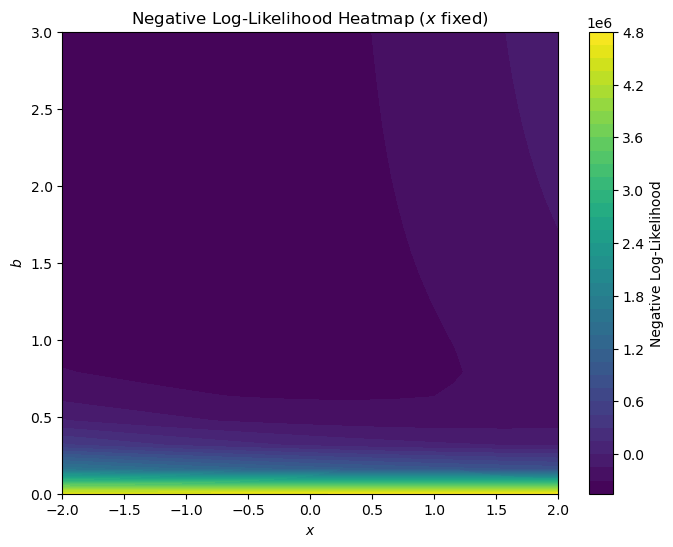

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the parameter grid for m0 and b
x_values = np.linspace(-2, 2, 20)
#m0_values = np.linspace(1.5, 2.5, 10)
b_values = np.linspace(0, 3, 20)

# Calculate likelihoods for a fixed x
#x_fixed = 1.7
m0_fixed = 18
#b_fixed = 0.5
likelihoods = np.zeros((len(x_values), len(b_values)))

for i, x in enumerate(tqdm(x_values)):
    for j, b in enumerate(b_values):
        params = [m0_fixed, b, x]
        likelihoods[i, j] = neg_likelihood(params,apr_mag_r, k_rr, d_desi, apr_mag_r_err)

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(x_values, b_values, likelihoods.T, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('$x$')
plt.ylabel('$b$')
plt.title('Negative Log-Likelihood Heatmap ($x$ fixed)')
plt.show()